In [2]:
import sys
import uproot3 as uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
import pickle
import xgboost as xgb

from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope
from tqdm import tqdm

In [3]:
%matplotlib inline
plt.ion()

In [4]:
# data frame to hold all data
datafile = uproot.open("/Users/patrick/Documents/MicroBooNE/CrossSections/NuePiXSec_Analysis/BDTTraining/electronPhoton/TrainingTree_ElectronPhotonSeparation_FHC_Nov2023.root")["trainingTree"]

variables = (
    "isSignal",
    
    "n_showers_contained",
    "shr_distance",
    "shr_trkfit_gap10_dedx_max",
    "shr_trkfit_2cm_dedx_max",
    "shrmoliereavg",
    "shr_energyFraction",
    "shrsubclusters",
    "shrPCA1CMed_5cm",
    "CylFrac2h_1cm",
    "DeltaRMS2h",
    "shrMCSMom",
     
    "shr_energy_second_cali",
    "shr2_distance",
    "shr12_p1_dstart",
    "shr2_trackEndProximity",
    "shr2_pfpgeneration",
    
    "secondshower_Y_nhit",
    "secondshower_Y_vtxdist",
    "secondshower_Y_dot",
    "secondshower_Y_anglediff",
    "secondshower_U_nhit",
    "secondshower_U_vtxdist",
    "secondshower_U_dot",
    "secondshower_U_anglediff",
    "secondshower_V_nhit",
    "secondshower_V_vtxdist",
    "secondshower_V_dot",
    "secondshower_V_anglediff"
)

df = pd.DataFrame(datafile.arrays(namedecode='utf-8', branches=variables))

# shuffle to avoid intrinsic sample being at start
#df = df.sample(frac=1).reset_index(drop=True)

In [5]:
print(df.shape) 
print(df.keys())
df.head()

(44731, 29)
Index(['isSignal', 'n_showers_contained', 'shr_distance',
       'shr_trkfit_gap10_dedx_max', 'shr_trkfit_2cm_dedx_max', 'shrmoliereavg',
       'shr_energyFraction', 'shrsubclusters', 'shrPCA1CMed_5cm',
       'CylFrac2h_1cm', 'DeltaRMS2h', 'shrMCSMom', 'shr_energy_second_cali',
       'shr2_distance', 'shr12_p1_dstart', 'shr2_trackEndProximity',
       'shr2_pfpgeneration', 'secondshower_Y_nhit', 'secondshower_Y_vtxdist',
       'secondshower_Y_dot', 'secondshower_Y_anglediff', 'secondshower_U_nhit',
       'secondshower_U_vtxdist', 'secondshower_U_dot',
       'secondshower_U_anglediff', 'secondshower_V_nhit',
       'secondshower_V_vtxdist', 'secondshower_V_dot',
       'secondshower_V_anglediff'],
      dtype='object')


,isSignal,n_showers_contained,shr_distance,shr_trkfit_gap10_dedx_max,shr_trkfit_2cm_dedx_max,shrmoliereavg,shr_energyFraction,shrsubclusters,shrPCA1CMed_5cm,CylFrac2h_1cm,...,secondshower_Y_dot,secondshower_Y_anglediff,secondshower_U_nhit,secondshower_U_vtxdist,secondshower_U_dot,secondshower_U_anglediff,secondshower_V_nhit,secondshower_V_vtxdist,secondshower_V_dot,secondshower_V_anglediff
0,True,2.0,1.361847,2.391630,2.491226,4.280891,0.889582,19.0,0.749226,0.110811,...,0.952021,16.320152,26.0,77.409691,0.892312,16.692207,6.0,222.094467,0.873353,117.697388
1,True,1.0,4.306019,0.895024,4.533725,6.053484,1.000000,33.0,0.875136,0.384365,...,0.999895,16.723740,7.0,66.533485,0.958273,20.377441,15.0,49.797924,0.805578,69.659874
2,True,1.0,1.011665,1.921794,6.640382,5.618897,1.000000,26.0,0.755098,0.078505,...,0.990471,24.694702,120.0,37.359657,0.855770,69.337563,43.0,12.003168,0.991874,36.981144
3,True,1.0,1.524562,4.395074,1.039313,3.088602,1.000000,30.0,0.792886,0.243373,...,0.806665,67.971069,4.0,242.963531,0.288863,8.512268,44.0,208.757004,0.936602,80.660110
4,True,1.0,3.959483,3.885626,4.496326,11.959663,1.000000,16.0,0.917910,0.044444,...,0.262010,74.674530,98.0,112.487328,0.835975,47.688683,7.0,14.291335,0.987896,52.240875


In [6]:
# calculate neg / pos weight
scale_weight = (df.query('isSignal == 0')).shape[0] / (df.query('isSignal == 1')).shape[0]
print(scale_weight)

1.0823518458172339


In [7]:
print((df.query('isSignal == 0')).shape[0])
print((df.query('isSignal == 1')).shape[0])

23250
21481


In [6]:
# splitting into testing and training samples
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 1)
labels_train = df_train["isSignal"]
labels_test = df_test["isSignal"]

df_train_sig = df_train.query("isSignal == True")
df_train_bkg = df_train.query("isSignal == False")
df_test_sig = df_test.query("isSignal == True")
df_test_bkg = df_test.query("isSignal == False")

In [7]:
# convert to DMatrix format
missing_value = 9999
bdt_vars = {
    "n_showers_contained",
    "shr_distance",
    "shr_trkfit_gap10_dedx_max",
    "shr_trkfit_2cm_dedx_max",
    "shrmoliereavg",
    "shr_energyFraction",
    "shrsubclusters",
    "shrPCA1CMed_5cm",
    "CylFrac2h_1cm",
    "DeltaRMS2h",
    "shrMCSMom",
     
    "shr_energy_second_cali",
    "shr2_distance",
    "shr12_p1_dstart",
    "shr2_trackEndProximity",
    "shr2_pfpgeneration",
    
    "secondshower_Y_nhit",
    "secondshower_Y_vtxdist",
    "secondshower_Y_dot",
    "secondshower_Y_anglediff",
    "secondshower_U_nhit",
    "secondshower_U_vtxdist",
    "secondshower_U_dot",
    "secondshower_U_anglediff",
    "secondshower_V_nhit",
    "secondshower_V_vtxdist",
    "secondshower_V_dot",
    "secondshower_V_anglediff"
}

xgb_train_dict = xgb.DMatrix(df_train[bdt_vars], label=labels_train, missing=missing_value, feature_names=bdt_vars)
xgb_train_sig_dict = xgb.DMatrix(df_train_sig[bdt_vars], label=df_train_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
xgb_train_bkg_dict = xgb.DMatrix(df_train_bkg[bdt_vars], label=df_train_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)

xgb_test_dict = xgb.DMatrix(df_test[bdt_vars], label=labels_test, missing=missing_value, feature_names=bdt_vars)
xgb_test_sig_dict = xgb.DMatrix(df_test_sig[bdt_vars], label=df_test_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
xgb_test_bkg_dict = xgb.DMatrix(df_test_bkg[bdt_vars], label=df_test_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)

/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_75384/2372294200.py:36: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_dict = xgb.DMatrix(df_train[bdt_vars], label=labels_train, missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_75384/2372294200.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_sig_dict = xgb.DMatrix(df_train_sig[bdt_vars], label=df_train_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_75384/2372294200.py:38: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_bkg_dict = xgb.DMatrix(df_train_bkg[bdt_vars], label=df_train_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l6

In [77]:
# configuring XGBoost 
xgb_param = {'booster': 'dart',
        'max_depth':5,
        'eta': 0.03,
        'gamma': 1,
        'objective':'binary:logistic',
        'tree_method':'hist',
        'rate_drop': 0.1,
        'skip_drop': 0.5,
        'scale_pos_weight': scale_weight,
        'nthread' : 6,
        'random_state': 0 }

num_round = 500
progress = dict()

watchlist = [(xgb_train_dict, 'train'), (xgb_test_dict, 'test'), (xgb_test_sig_dict, 'test_sig'), (xgb_test_bkg_dict, 'test_bkg')]

In [30]:
# HyperOpt Aug 10
#{'colsample_bytree': 0.7747664542041863,
#'eta': 0.05140985915968113,
#'gamma': 1.0659827151260441,
#'max_depth': 6, 
#'min_child_weight': 8.024849496961474, 
#'subsample': 0.6433568683737285}
#500
# configuring XGBoost (Optimised values using HyperOpt)
xgb_param = {'booster': 'dart',
        'max_depth':6,
        'eta': 0.05,
        'gamma': 0.75,
        'min_child_weight': 5.0,
        'subsample': 0.75,
        'objective':'binary:logistic',
        'tree_method':'hist',
        'rate_drop': 0.1,
        'skip_drop': 0.5,    
        'scale_pos_weight': scale_weight,
        'nthread' : 6, 
        'random_state': 27} #27}

num_round = 200
progress = dict()

watchlist = [(xgb_train_dict, 'train'), (xgb_test_dict, 'test'), (xgb_test_sig_dict, 'test_sig'), (xgb_test_bkg_dict, 'test_bkg')]

In [31]:
# training
bdt = xgb.train(xgb_param, xgb_train_dict, num_round, watchlist, evals_result=progress, verbose_eval=False)

In [34]:
# save pickle 
pickle.dump(bdt, open("electronPhotonBDT.pickle.dat", "wb"))

In [35]:
# load from pickle
bdt = pickle.load(open("electronPhotonBDT.pickle.dat", "rb"))

In [36]:
# save model
bdt.save_model("bdt_electronPhoton.model")
bdt.save_model("bdt_electronPhoton.json")

In [157]:
bdt.dump_model("bdt_electronPhotondump.txt")

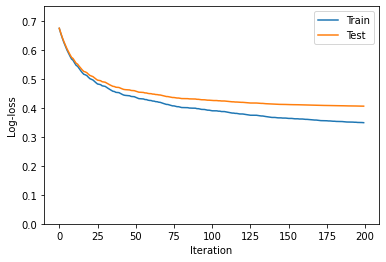

0.34878325995096726 0.4057716918560286


In [41]:
# plot training rate
results = progress
epochs = len(results['train']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['train']['logloss'], label='Train')
ax.plot(x_axis, results['test']['logloss'], label='Test')
ax.legend()
plt.ylim(0, 0.75)
plt.xlabel("Iteration")
plt.ylabel("Log-loss")
plt.show()

print(results['train']['logloss'][-1], results['test']['logloss'][-1])
#fig.savefig("training_rate_electronphoton_fhc.pdf", format="pdf")

<Figure size 1440x1440 with 0 Axes>

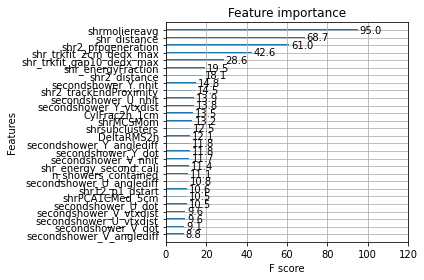

In [38]:
# plot importances
importance = bdt.get_score(importance_type="gain")

for key in importance.keys():
        importance[key] = round(importance[key],1)

# plotting importances of variables
plt.figure(figsize=(20,20),facecolor='white')
a = xgb.plot_importance(importance,max_num_features=30,importance_type='gain')
plt.xlim(0, 120)
plt.tight_layout()
#plt.savefig("feature_importance_electronphoton_fhc.pdf", format="pdf")

<Figure size 432x288 with 0 Axes>

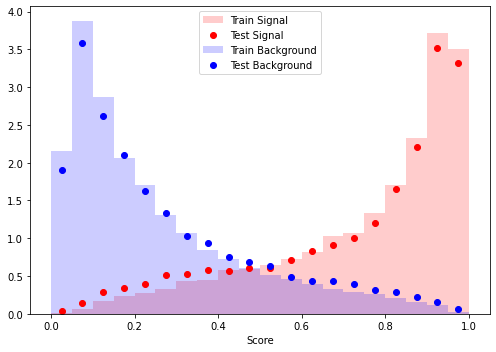

In [40]:
# plot test vs training
predictions_train_sig = bdt.predict(xgb_train_sig_dict)
predictions_train_bkg = bdt.predict(xgb_train_bkg_dict)
predictions_test_sig = bdt.predict(xgb_test_sig_dict)
predictions_test_bkg = bdt.predict(xgb_test_bkg_dict)

hist_range=[0,1.0]
n_bins=20

plt.figure(figsize=(7,5))
plt.hist(predictions_train_sig,bins=n_bins, range=hist_range, density=True,alpha=0.2,color='red',label='Train Signal' )
counts,bin_edges = np.histogram(predictions_test_sig,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers,counts,marker='o',linestyle="None",color='red',label='Test Signal')

plt.hist(predictions_train_bkg, bins = n_bins, range = hist_range, density = True, alpha = 0.2, color = 'blue', label = r'Train Background')
counts,bin_edges = np.histogram(predictions_test_bkg,bins = n_bins, range= hist_range,density = True)
bin_centers = (bin_edges[:-1] +  bin_edges[1:])/2.
plt.plot(bin_centers,counts,marker='o',linestyle ="None",color='blue',label = r'Test Background')
plt.legend()

plt.xlabel("Score")

plt.tight_layout()

#plt.savefig("performance_electronphoton_fhc.pdf", format="pdf")

<Figure size 432x288 with 0 Axes>

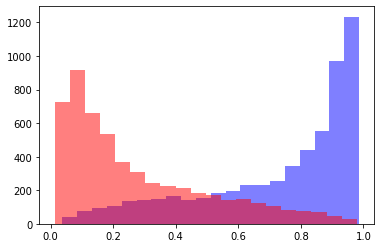

In [53]:
# create plot of predictions (testing samples)
num_bins = 20

plt.hist(predictions_test_sig, num_bins, color ='blue', alpha = 0.5)
plt.hist(predictions_test_bkg, num_bins, color ='red', alpha = 0.5)

plt.show()

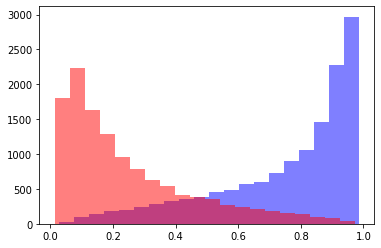

In [54]:
# create plot of predictions (training samples)
num_bins = 20
   
plt.hist(predictions_train_sig, num_bins, color ='blue', alpha = 0.5)
plt.hist(predictions_train_bkg, num_bins, color ='red', alpha = 0.5)

plt.show()

In [25]:
# Hyper parameter optimisation
# Un-tunded base case estimator to compare score
params_base = {'booster': 'dart',
               'objective': 'binary:logistic',
               'tree_method': 'hist',
               'rate_drop': 0.1,
               'skip_drop': 0.5,
               'scale_pos_weight': scale_weight,
               'random_state': 27}

base_model = xgb.train(params = params_base,
                       dtrain = xgb_train_dict,
                       num_boost_round = 250,
                       evals = [(xgb_test_dict,'eval')],
                       early_stopping_rounds=10,
                       verbose_eval = 20)

y_pred_base = base_model.predict(xgb_test_dict)

base_score = log_loss(df_test["isSignal"].values, y_pred_base)
print(base_score)

[0]	eval-logloss:0.59620
[20]	eval-logloss:0.41955
[40]	eval-logloss:0.41199
[60]	eval-logloss:0.40964
[80]	eval-logloss:0.40782
[92]	eval-logloss:0.40776
0.4077245616530579


In [78]:
# Simple Cross Val score as function to be optimised
def score(params):
    
    ps = {'eta': params['eta'],
         'max_depth': params['max_depth'], 
         'gamma': params['gamma'],
         'min_child_weight': params['min_child_weight'], 
         'subsample': params['subsample'], 
         'colsample_bytree': params['colsample_bytree'], 
         'verbosity': 1, 
         'objective': 'binary:logistic',
         'booster': 'dart',
         'eval_metric': 'logloss', 
         'tree_method': 'hist', 
         'rate_drop': 0.1,
         'skip_drop': 0.5,    
         'scale_pos_weight': scale_weight,
         'random_state': 27,
         }
    model = xgb.train(ps,xgb_train_dict, params['n_round'], [(xgb_test_dict, 'eval')], early_stopping_rounds=10, verbose_eval = False)
    y_pred = model.predict(xgb_test_dict)
    score = log_loss(df_test["isSignal"].values, y_pred)

    return score

In [79]:
# Define parameter space
param_space = {'eta': hp.uniform('eta', 0.01, 0.3), 
               'n_round': scope.int(hp.quniform('n_round', 100, 400, 50)),
               'max_depth': scope.int(hp.quniform('max_depth', 3, 8, 1)), 
               'gamma': hp.uniform('gamma', 0.5, 10), 
               'min_child_weight': hp.uniform('min_child_weight', 0.5, 10),
               'subsample': hp.uniform('subsample', 0.1, 1), 
               'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),  
              }


In [80]:
# Run optimiser with tpe
%time
trials = Trials()

hopt = fmin(fn = score,
            space = param_space, 
            algo = tpe.suggest, 
            max_evals = 100, ## 100
            trials = trials, 
           )

params_best = hopt
params_best['max_depth'] = int(hopt['max_depth'])
n_rounds_best = int(hopt['n_round'])
del params_best['n_round']
print(params_best)
print(n_rounds_best)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 34.8 µs
  0%|                                                                                                                     | 0/100 [00:00<?, ?trial/s, best loss=?]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  1%|▉                                                                                          | 1/100 [00:26<43:15, 26.21s/trial, best loss: 0.4061331083456982]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  2%|█▊                                                                                         | 2/100 [01:00<50:55, 31.18s/trial, best loss: 0.4061331083456982]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  3%|██▋                                                                                        | 3/100 [01:21<42:39, 26.38s/trial, best loss: 0.4061331083456982]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  4%|███▋                                                                                       | 4/100 [01:31<31:50, 19.90s/trial, best loss: 0.4061331083456982]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  5%|████▌                                                                                      | 5/100 [01:39<24:45, 15.64s/trial, best loss: 0.4061331083456982]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  6%|█████▍                                                                                     | 6/100 [02:09<32:18, 20.62s/trial, best loss: 0.4061331083456982]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  7%|██████▎                                                                                    | 7/100 [03:04<49:00, 31.62s/trial, best loss: 0.4061331083456982]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  8%|███████▎                                                                                   | 8/100 [03:36<48:56, 31.92s/trial, best loss: 0.4061331083456982]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  9%|████████                                                                                  | 9/100 [03:46<38:00, 25.06s/trial, best loss: 0.40547311473611863]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 10%|████████▉                                                                                | 10/100 [04:06<35:14, 23.50s/trial, best loss: 0.40547311473611863]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 11%|█████████▉                                                                                | 11/100 [04:25<32:45, 22.09s/trial, best loss: 0.4047270557108137]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 12%|██████████▊                                                                               | 12/100 [04:29<24:22, 16.61s/trial, best loss: 0.4047270557108137]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 13%|███████████▋                                                                              | 13/100 [05:40<47:56, 33.06s/trial, best loss: 0.4025451651765543]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 14%|████████████▎                                                                           | 14/100 [07:18<1:15:17, 52.53s/trial, best loss: 0.4025451651765543]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 15%|█████████████▏                                                                          | 15/100 [07:41<1:01:58, 43.74s/trial, best loss: 0.4025451651765543]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 16%|██████████████▍                                                                           | 16/100 [07:54<48:26, 34.61s/trial, best loss: 0.4025451651765543]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 17%|███████████████▎                                                                          | 17/100 [08:48<55:57, 40.45s/trial, best loss: 0.4025451651765543]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 18%|████████████████▏                                                                         | 18/100 [09:21<52:04, 38.11s/trial, best loss: 0.4025451651765543]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 19%|████████████████▋                                                                       | 19/100 [10:25<1:01:51, 45.82s/trial, best loss: 0.4025451651765543]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 20%|██████████████████                                                                        | 20/100 [10:55<54:41, 41.02s/trial, best loss: 0.4025451651765543]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 21%|██████████████████▍                                                                     | 21/100 [13:24<1:36:54, 73.61s/trial, best loss: 0.4004236315421419]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 22%|███████████████████▎                                                                    | 22/100 [15:38<1:59:05, 91.61s/trial, best loss: 0.4004236315421419]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 23%|████████████████████                                                                   | 23/100 [18:15<2:22:37, 111.14s/trial, best loss: 0.4004236315421419]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 24%|████████████████████▉                                                                  | 24/100 [19:32<2:08:09, 101.18s/trial, best loss: 0.4004236315421419]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 25%|█████████████████████▊                                                                 | 25/100 [21:26<2:11:08, 104.91s/trial, best loss: 0.4001293848892067]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 26%|██████████████████████▌                                                                | 26/100 [24:05<2:29:20, 121.09s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 27%|███████████████████████▊                                                                | 27/100 [24:26<1:50:53, 91.14s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 28%|████████████████████████▋                                                               | 28/100 [24:33<1:18:58, 65.82s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 29%|█████████████████████████▌                                                              | 29/100 [26:58<1:46:05, 89.66s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 30%|██████████████████████████▍                                                             | 30/100 [28:19<1:41:28, 86.98s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 31%|███████████████████████████▎                                                            | 31/100 [28:42<1:17:54, 67.74s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 32%|████████████████████████████▏                                                           | 32/100 [29:42<1:14:06, 65.40s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 33%|█████████████████████████████▋                                                            | 33/100 [29:53<54:46, 49.06s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 34%|█████████████████████████████▉                                                          | 34/100 [31:10<1:03:08, 57.40s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 35%|██████████████████████████████▊                                                         | 35/100 [32:54<1:17:36, 71.64s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 36%|███████████████████████████████▋                                                        | 36/100 [33:56<1:13:04, 68.50s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 37%|█████████████████████████████████▎                                                        | 37/100 [34:01<51:54, 49.44s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 38%|██████████████████████████████████▏                                                       | 38/100 [34:54<52:21, 50.66s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 39%|███████████████████████████████████                                                       | 39/100 [34:59<37:41, 37.07s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 40%|████████████████████████████████████                                                      | 40/100 [35:48<40:40, 40.68s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 41%|████████████████████████████████████▉                                                     | 41/100 [36:01<31:40, 32.21s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 42%|█████████████████████████████████████▊                                                    | 42/100 [36:43<34:05, 35.27s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 43%|██████████████████████████████████████▋                                                   | 43/100 [37:37<38:45, 40.79s/trial, best loss: 0.3997868208510593]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 44%|███████████████████████████████████████▌                                                  | 44/100 [39:20<55:29, 59.46s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 45%|████████████████████████████████████████▌                                                 | 45/100 [39:30<40:59, 44.72s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 46%|████████████████████████████████████████▍                                               | 46/100 [41:49<1:05:41, 72.99s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 47%|██████████████████████████████████████████▎                                               | 47/100 [41:55<46:42, 52.87s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 48%|███████████████████████████████████████████▏                                              | 48/100 [42:14<37:00, 42.70s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 49%|████████████████████████████████████████████                                              | 49/100 [42:38<31:27, 37.01s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 50%|█████████████████████████████████████████████                                             | 50/100 [42:58<26:40, 32.01s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 51%|█████████████████████████████████████████████▉                                            | 51/100 [43:31<26:14, 32.14s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 52%|██████████████████████████████████████████████▊                                           | 52/100 [44:00<25:00, 31.26s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 53%|███████████████████████████████████████████████▋                                          | 53/100 [44:26<23:09, 29.57s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 54%|████████████████████████████████████████████████▌                                         | 54/100 [44:53<22:06, 28.85s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 55%|█████████████████████████████████████████████████▌                                        | 55/100 [46:22<35:14, 47.00s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 56%|██████████████████████████████████████████████████▍                                       | 56/100 [48:10<47:56, 65.39s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 57%|██████████████████████████████████████████████████▏                                     | 57/100 [50:25<1:01:49, 86.28s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 58%|████████████████████████████████████████████████████▏                                     | 58/100 [50:45<46:28, 66.39s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 59%|█████████████████████████████████████████████████████                                     | 59/100 [51:34<41:45, 61.12s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 60%|██████████████████████████████████████████████████████                                    | 60/100 [52:01<33:54, 50.86s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 61%|██████████████████████████████████████████████████████▉                                   | 61/100 [54:16<49:25, 76.05s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 62%|███████████████████████████████████████████████████████▊                                  | 62/100 [55:21<46:03, 72.72s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 63%|████████████████████████████████████████████████████████▋                                 | 63/100 [55:26<32:25, 52.58s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 64%|█████████████████████████████████████████████████████████▌                                | 64/100 [55:31<22:51, 38.09s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 65%|██████████████████████████████████████████████████████████▌                               | 65/100 [55:42<17:34, 30.12s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 66%|███████████████████████████████████████████████████████████▍                              | 66/100 [56:18<18:01, 31.80s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 67%|████████████████████████████████████████████████████████████▎                             | 67/100 [56:52<17:51, 32.48s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 68%|█████████████████████████████████████████████████████████████▏                            | 68/100 [57:27<17:41, 33.16s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 69%|██████████████████████████████████████████████████████████████                            | 69/100 [59:51<34:17, 66.37s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 70%|█████████████████████████████████████████████████████████████▌                          | 70/100 [1:00:14<26:39, 53.31s/trial, best loss: 0.3997060054370835]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 71%|██████████████████████████████████████████████████████████████▍                         | 71/100 [1:01:43<31:03, 64.26s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 72%|███████████████████████████████████████████████████████████████▎                        | 72/100 [1:03:30<35:55, 76.98s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 73%|████████████████████████████████████████████████████████████████▏                       | 73/100 [1:04:05<28:58, 64.39s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 74%|█████████████████████████████████████████████████████████████████                       | 74/100 [1:04:51<25:31, 58.89s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 75%|██████████████████████████████████████████████████████████████████                      | 75/100 [1:05:03<18:42, 44.92s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 76%|██████████████████████████████████████████████████████████████████▉                     | 76/100 [1:06:52<25:39, 64.13s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 77%|███████████████████████████████████████████████████████████████████▊                    | 77/100 [1:07:15<19:49, 51.73s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 78%|████████████████████████████████████████████████████████████████████▋                   | 78/100 [1:09:05<25:22, 69.20s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 79%|█████████████████████████████████████████████████████████████████████▌                  | 79/100 [1:10:25<25:18, 72.33s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 80%|██████████████████████████████████████████████████████████████████████▍                 | 80/100 [1:11:27<23:09, 69.47s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 81%|███████████████████████████████████████████████████████████████████████▎                | 81/100 [1:12:07<19:09, 60.48s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 82%|████████████████████████████████████████████████████████████████████████▏               | 82/100 [1:13:29<20:07, 67.06s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 83%|█████████████████████████████████████████████████████████████████████████               | 83/100 [1:14:09<16:39, 58.81s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 84%|█████████████████████████████████████████████████████████████████████████▉              | 84/100 [1:14:25<12:16, 46.02s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 85%|██████████████████████████████████████████████████████████████████████████▊             | 85/100 [1:15:25<12:30, 50.02s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 86%|███████████████████████████████████████████████████████████████████████████▋            | 86/100 [1:16:02<10:48, 46.30s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 87%|████████████████████████████████████████████████████████████████████████████▌           | 87/100 [1:17:23<12:18, 56.78s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 88%|█████████████████████████████████████████████████████████████████████████████▍          | 88/100 [1:17:47<09:21, 46.75s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 89%|██████████████████████████████████████████████████████████████████████████████▎         | 89/100 [1:19:10<10:34, 57.64s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 90%|███████████████████████████████████████████████████████████████████████████████▏        | 90/100 [1:19:32<07:51, 47.10s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 91%|████████████████████████████████████████████████████████████████████████████████        | 91/100 [1:19:44<05:27, 36.35s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 92%|████████████████████████████████████████████████████████████████████████████████▉       | 92/100 [1:21:33<07:45, 58.17s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 93%|█████████████████████████████████████████████████████████████████████████████████▊      | 93/100 [1:22:24<06:32, 56.02s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 94%|██████████████████████████████████████████████████████████████████████████████████▋     | 94/100 [1:23:52<06:34, 65.68s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 95%|███████████████████████████████████████████████████████████████████████████████████▌    | 95/100 [1:24:02<04:04, 48.99s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 96%|████████████████████████████████████████████████████████████████████████████████████▍   | 96/100 [1:24:54<03:19, 49.87s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 97%|█████████████████████████████████████████████████████████████████████████████████████▎  | 97/100 [1:25:04<01:53, 37.86s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 98/100 [1:25:25<01:06, 33.02s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 99%|███████████████████████████████████████████████████████████████████████████████████████ | 99/100 [1:25:34<00:25, 25.58s/trial, best loss: 0.3979113726344205]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:26:35<00:00, 51.96s/trial, best loss: 0.3979113726344205]
{'colsample_bytree': 0.9261288617109794, 'eta': 0.08112553880532908, 'gamma': 1.1871717040801593, 'max_depth': 7, 'min_child_weight': 5.588802281263023, 'subsample': 0.8991874277124994}
350


In [81]:
print(params_best)
print(n_rounds_best)

{'colsample_bytree': 0.9261288617109794, 'eta': 0.08112553880532908, 'gamma': 1.1871717040801593, 'max_depth': 7, 'min_child_weight': 5.588802281263023, 'subsample': 0.8991874277124994}
350
